In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from adjustText import adjust_text
from statannot import add_stat_annotation

import pandas as pd
import seaborn as sns
import os
import re

import pickle
import json

In [2]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    return ax
    
def same_ticks(ax):
    
    # Make ticks the same
    ax.set_xticks(ax.get_yticks())
    ax.set_xticklabels([aa.get_text() for aa in ax.get_yticklabels()])
    
    return ax

You will need to download the eye-tracking data from HCP and store it locally (the data are too large to store on Github)

In [3]:
data_dir = '../data/eye_tracking_data/'

In [4]:
print(len(os.listdir(data_dir)))
os.listdir(data_dir)[:10]

2932


['125525_7T_REST4_eyetrack.asc',
 '173334_7T_REST4_eyetrack_summary.csv',
 '601127_7T_REST1_eyetrack_summary.csv',
 '115017_7T_MOV2_eyetrack_summary.csv',
 '173334_7T_MOV2_eyetrack.asc',
 '905147_7T_MOV4_eyetrack_summary.csv',
 '385046_7T_REST2_eyetrack_summary.csv',
 '180533_7T_REST2_eyetrack.asc',
 '380036_7T_MOV2_eyetrack.asc',
 '901442_7T_REST1_eyetrack.asc']

In [5]:
all_files = os.listdir(data_dir)
bad_files = []
good_files = []
for file in all_files:
    if '_eyetrack_summary.csv' in file:
        if pd.read_csv(data_dir+file).shape==(1,16):
            good_files.append(file)
        else:
            bad_files.append(file)

print("{} good files found".format(len(good_files)))
print("{} bad files found".format(len(bad_files)))

1216 good files found
248 bad files found


In [6]:
for f, file in enumerate(good_files):
    if f==0:
        eye_data = pd.read_csv(data_dir+file)
    elif f>0:
        eye_data = eye_data.append(pd.read_csv(data_dir+file))

In [8]:
short_to_long = {
    "MOV1": "MOVIE1",
    "MOV2": "MOVIE2",
    "MOV3": "MOVIE3",
    "MOV4": "MOVIE4"
}


eye_data = eye_data.replace(short_to_long)

In [9]:
eye_data.head()

,subject,scan,block,failsafe,startline,endline,numlines,srate,durexpected,duration,durfrac,eyefrac,TRcount,TRonset,TRduration,TRfrac
0,134627,MOVIE2,1,0,50,1009182,1009133,1000,918,1000.005,108.933,80.492,918,81.217,918.788,100.085
0,966975,REST2,1,0,56,1004440,1004385,1000,900,997.481,110.831,49.692,900,97.383,900.098,100.010
0,187345,REST2,1,0,50,1045702,1045653,1000,900,1040.616,115.624,39.229,900,140.526,900.090,100.010
0,182436,MOVIE3,1,0,95,1049058,1048964,1000,915,1036.225,113.248,84.809,915,120.429,915.796,100.086
0,172130,REST3,1,0,56,993153,993098,1000,900,990.972,110.108,52.469,900,90.888,900.084,100.009


In [10]:
len(eye_data["subject"].unique())

166

In [11]:
runs_of_interest = ['REST1',
        'MOVIE1',
        'MOVIE2',
        'REST4',
        'MOVIE3',        
        'MOVIE4',
        ]

eye_data[eye_data["scan"].isin(runs_of_interest)]["srate"].value_counts()

1000    835
500      96
Name: srate, dtype: int64

## First-pass analyses to see if there are broad differences in eyes-open timepoints between scan conditions

In [12]:
eye_data_wide = eye_data.pivot(index="subject", columns="scan")["eyefrac"]
eye_data_wide.head()

scan,MOVIE1,MOVIE2,MOVIE3,MOVIE4,REST1,REST2,REST3,REST4
subject,,,,,,,,
100610,94.607,97.712,96.831,94.795,94.750,87.535,98.224,96.191
102311,4.053,0.730,77.814,64.550,NaN,61.934,75.340,62.915
102816,9.079,16.654,17.774,12.486,20.504,2.217,18.722,4.686
104416,19.093,46.095,66.301,77.142,0.067,72.633,80.533,55.131
105923,96.024,96.216,96.472,96.636,63.399,83.802,95.454,95.234


Performing paired t-test on pair: ('REST1', 'MOVIE1') stat=-1.48e+00 p-value=1.42e-01 df = 139
Performing paired t-test on pair: ('REST1', 'MOVIE2') stat=-5.47e-01 p-value=5.85e-01 df = 138
pvalues: [0.14235474913336438, 0.5850218767092321]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST1 v.s. MOVIE1: Custom statistical test, P_val:1.424e-01
REST1 v.s. MOVIE2: Custom statistical test, P_val:5.850e-01
Performing paired t-test on pair: ('REST4', 'MOVIE3') stat=-2.17e+00 p-value=3.20e-02 df = 143
Performing paired t-test on pair: ('REST4', 'MOVIE4') stat=-1.16e+00 p-value=2.50e-01 df = 144
pvalues: [0.032002703399434416, 0.24980662203726384]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST4 v.s. MOVIE3: Custom statistical test, P_val:3.200e-02
REST4 v.

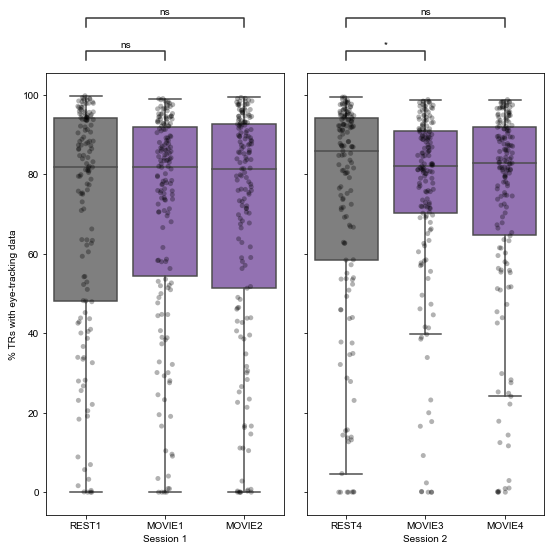

In [14]:
save_fig = False

scan_order = ['REST1',
        'MOVIE1',
        'MOVIE2',
        'REST4',
        'MOVIE3',        
        'MOVIE4',
        ]

my_palette = {"REST1": "tab:gray", 
              "REST4": "tab:gray",
              "MOVIE1": "tab:purple",
              "MOVIE2": "tab:purple",
              "MOVIE3": "tab:purple",
              "MOVIE4": "tab:purple",
             }

# Plot group average
data = eye_data_wide
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8), sharey=True)

# Do session 1
ax = ax1
order1 = ["REST1", "MOVIE1", "MOVIE2"]
sns.boxplot(data=data, 
              order=order1,
              palette=my_palette,
              ax=ax,
            showfliers=False
            ),
sns.stripplot(data=data, 
              ax=ax1,
             color="black", alpha = 0.3,
            order = order1,
             )

box_pairs=[("REST1", "MOVIE1"), ("REST1", "MOVIE2")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = data[pair[0]]
    data2 = data[pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df = {}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)
test_results = add_stat_annotation(ax, data=data, order=order1,
                                  box_pairs=[("REST1", "MOVIE1"), ("REST1", "MOVIE2")],
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  )

# Do session 2
ax = ax2
order2 = ["REST4", "MOVIE3", "MOVIE4"]
sns.boxplot(data=data, 
              order=order2,
              palette=my_palette,
              ax=ax,
            showfliers=False
            ),
sns.stripplot(data=data, 
              ax=ax,
             color="black", alpha = 0.3,
            order = order2,
             )

box_pairs=[("REST4", "MOVIE3"), ("REST4", "MOVIE4")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = data[pair[0]]
    data2 = data[pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df = {}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)
test_results = add_stat_annotation(ax, data=data, order=order2,
                                  box_pairs=box_pairs,
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  )

sns.set(font_scale=1.5, style="white")
ax1.set_ylabel("% TRs with eye-tracking data")
ax1.set_xlabel('Session 1')
ax2.set_xlabel('Session 2')
ax2.yaxis.label.set_visible(False)

fig.tight_layout()

if save_fig == True:
    plt.savefig('WholeRunResults_pctTRwEyeTrackingData.jpg', dpi=300)

## Read in the actual eye-tracking logs

Some subjects had a 500 Hz sampling rate instead of 1000:

In [15]:
eye_data["srate"].value_counts()

1000    1089
500      127
Name: srate, dtype: int64

In [16]:
video_tr_lookup = pd.read_csv('../data/video_tr_lookup.csv')
video_tr_lookup

,clipno_overall,run,clipno_in_run,clip_name,start_tr,stop_tr
0,1,MOVIE1_7T_AP,1,twomen,20,265
1,2,MOVIE1_7T_AP,2,bridgeville,285,506
2,3,MOVIE1_7T_AP,3,pockets,526,714
3,4,MOVIE1_7T_AP,4,overcome,735,798
4,5,MOVIE1_7T_AP,5,testretest1,818,901
5,6,MOVIE2_7T_PA,1,inception,20,248
6,7,MOVIE2_7T_PA,2,socialnet,267,526
7,8,MOVIE2_7T_PA,3,oceans,545,795
8,9,MOVIE2_7T_PA,4,testretest2,815,898
9,10,MOVIE3_7T_PA,1,flower,20,200


In [24]:
video_tr_lookup["clip_name"].values

array(['twomen', 'bridgeville', 'pockets', 'overcome', 'testretest1',
       'inception', 'socialnet', 'oceans', 'testretest2', 'flower',
       'hotel', 'garden', 'dreary', 'testretest3', 'homealone',
       'brokovich', 'starwars', 'testretest4'], dtype=object)

In [17]:
def read_in_eye_data(data_dir, subj, clip, start_stop_pads=(5,0), n_trs=None, verbose=False):
    
    long_to_short = {
        "MOVIE1": "MOV1",
        "MOVIE2": "MOV2",
        "MOVIE3": "MOV3",
        "MOVIE4": "MOV4",
        "REST1": "REST1",
        "REST4": "REST4",
    }
    
    end_tr_lookup = {
        "MOV1": 921,
        "MOV2": 918,
        "MOV3": 915,
        "MOV4": 901,
        "REST1": 900,
        "REST4": 900,
    }
    
    run_name_lookup = {
        "MOVIE1_7T_AP": "MOV1", 
        "MOVIE2_7T_PA": "MOV2", 
        "MOVIE3_7T_PA": "MOV3", 
        "MOVIE4_7T_AP": "MOV4"
    }
    
    
    if any(x in clip for x in ['REST','MOVIE']): # if this is a full run
        file = subj + '_7T_' + long_to_short[clip] + '_eyetrack'
        start_tr = 1
        if n_trs is None:
            end_tr = end_tr_lookup[long_to_short[clip]]
        elif n_trs is not None:
            end_tr = start_tr + n_trs
    else: # if this is an individual clip
        run_name = video_tr_lookup.query('clip_name==@clip')["run"].tolist()[0] # figure out which run this clip is in
        file = subj + '_7T_' + run_name_lookup[run_name] + '_eyetrack'
        start_tr = video_tr_lookup.loc[video_tr_lookup["clip_name"]==clip, "start_tr"].values[0]+start_stop_pads[0]
        if n_trs is None:
            end_tr = video_tr_lookup.loc[video_tr_lookup["clip_name"]==clip, "stop_tr"].values[0]+start_stop_pads[1]
        elif n_trs is not None:
            end_tr = start_tr + n_trs
    
    # Check if there is good data for this subject and this file
    try:
        summary = pd.read_csv(data_dir+file+'_summary.csv')
        if summary.shape==(1,16) and (summary["srate"]==1000).values[0]:

            if verbose is True:
                print("File is {}".format(file))
                print("Start-stop TRs are: {},{}".format(start_tr, end_tr))

            with open(data_dir+file+'.asc', 'r') as f:
                line_number=0
                for line in f:
                    if 'TRIALID ' + str(start_tr)+'\n' in line:
                        startline = line_number
                    if 'TRIALID ' + str(end_tr) in line:
                        endline = line_number
                    line_number +=1

            data = []

            try: # some files just don't seem to have TR triggers in them, leading to a 'startline referenced before assignment' error...
                with open(data_dir+file+'.asc', 'r') as f:
                    good_lines=0
                    for l,line in enumerate(f):
                        if l>startline and l<endline:
                            try:
                                float(line.split('\t')[0]) # if the first column is a timestamp...
                                line = [item.replace(' .', 'nan') for item in line.split('\t')[:4]] # ...first replace annoying periods denoting missing data points
                                data.append([float(x) for x in line]) # then make them into floats and append them
                                good_lines+=1
                            except:
                                pass
                if verbose is True:
                    print("Total good_lines: {}".format(good_lines))
                if good_lines>0:
                    return data
            
            except:
                pass
    except:
        pass

In [18]:
def pear_corr(x,y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return sp.stats.pearsonr(x[~nas], y[~nas])

### Read in just the first 143 TRs for all subjects for all clips

The below cell only needs to be run ONCE, and it will take a while:

In [ ]:
n_trs = 143

clip_list=video_tr_lookup["clip_name"].tolist()
subj_list = np.load('subj_list.npy', allow_pickle=True)

# Read in data...this step will take a while
data = {}

for clip in clip_list:
    print("---------Doing clip {}---------".format(clip))
    data[clip] = {}
    for s,subj in enumerate(subj_list):
        print("Doing subject {} of {}".format(s+1, len(subj_list)))
        tmp = read_in_eye_data(data_dir, subj, clip, n_trs=n_trs)
        if tmp is not None:
            data[clip][subj] = tmp
        else:
            pass

# For whatever reason this subject gives a lot of trouble, so we just get rid of them
data["inception"].pop("146937")
data["socialnet"].pop("146937")
data["oceans"].pop("146937")

# Create ISC matrices (one per clip) for each of the three data streams (x-pos, y-pos and pupil dilation) and save them to json files 
for name, col in list(zip(['xpos', 'ypos', 'pupil'],[1,2,3])):
    isc_matrices = {}
    for clip in clip_list:
        print(clip)
        min_n_samples = np.min([len(x) for x in data[clip].values()])
        max_n_samples = np.max([len(x) for x in data[clip].values()])
        print("Min, max n samples: {}, {}".format(min_n_samples, max_n_samples))
        tmp = pd.DataFrame([np.array(x)[:min_n_samples,col] for x in data[clip].values()]).T.corr().values
        np.fill_diagonal(tmp, np.nan)
        isc_matrices[clip] = tmp
        
    f_name = '../data/isc_matrices_' + name + '_trs-143.json'
    with open(f_name, 'wb') as fp:
        pickle.dump(isc_matrices, fp)

---------Doing clip twomen---------
Doing subject 1 of 176
Doing subject 2 of 176
Doing subject 3 of 176
Doing subject 4 of 176
Doing subject 5 of 176
Doing subject 6 of 176
Doing subject 7 of 176
Doing subject 8 of 176
Doing subject 9 of 176
Doing subject 10 of 176
Doing subject 11 of 176
Doing subject 12 of 176
Doing subject 13 of 176
Doing subject 14 of 176
Doing subject 15 of 176
Doing subject 16 of 176
Doing subject 17 of 176
Doing subject 18 of 176
Doing subject 19 of 176
Doing subject 20 of 176
Doing subject 21 of 176
Doing subject 22 of 176
Doing subject 23 of 176
Doing subject 24 of 176
Doing subject 25 of 176
Doing subject 26 of 176
Doing subject 27 of 176
Doing subject 28 of 176
Doing subject 29 of 176
Doing subject 30 of 176
Doing subject 31 of 176
Doing subject 32 of 176
Doing subject 33 of 176
Doing subject 34 of 176
Doing subject 35 of 176
Doing subject 36 of 176
Doing subject 37 of 176
Doing subject 38 of 176
Doing subject 39 of 176
Doing subject 40 of 176
Doing subject

Doing subject 159 of 176
Doing subject 160 of 176
Doing subject 161 of 176
Doing subject 162 of 176
Doing subject 163 of 176
Doing subject 164 of 176
Doing subject 165 of 176
Doing subject 166 of 176
Doing subject 167 of 176
Doing subject 168 of 176
Doing subject 169 of 176
Doing subject 170 of 176
Doing subject 171 of 176
Doing subject 172 of 176
Doing subject 173 of 176
Doing subject 174 of 176
Doing subject 175 of 176
Doing subject 176 of 176
---------Doing clip pockets---------
Doing subject 1 of 176
Doing subject 2 of 176
Doing subject 3 of 176
Doing subject 4 of 176
Doing subject 5 of 176
Doing subject 6 of 176
Doing subject 7 of 176
Doing subject 8 of 176
Doing subject 9 of 176
Doing subject 10 of 176
Doing subject 11 of 176
Doing subject 12 of 176
Doing subject 13 of 176
Doing subject 14 of 176
Doing subject 15 of 176
Doing subject 16 of 176
Doing subject 17 of 176
Doing subject 18 of 176
Doing subject 19 of 176
Doing subject 20 of 176
Doing subject 21 of 176
Doing subject 22 o

In [7]:
name = 'xpos'

f_name = '../data/isc_matrices_' + name + '_trs-143.json'
with open(f_name, 'rb') as f:
    isc_matrices = pickle.load(f)

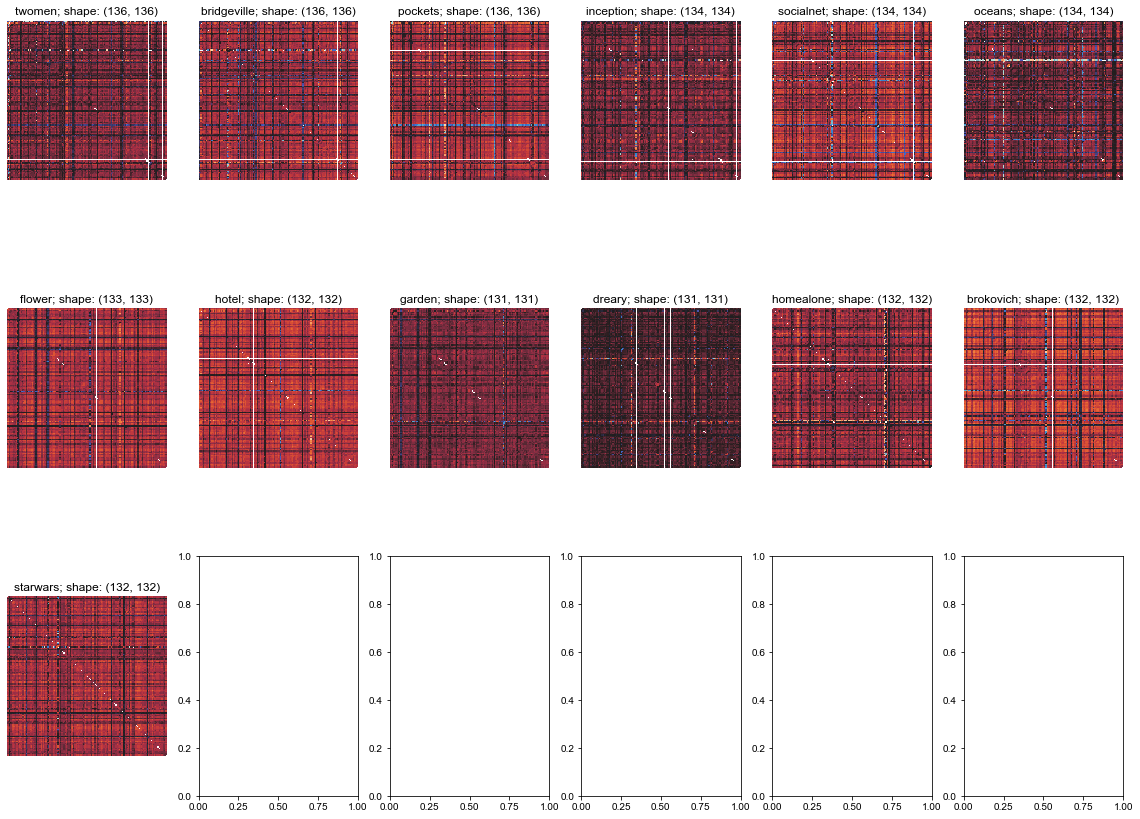

In [8]:
fig, axes = plt.subplots(3,6, figsize=(20,15))
sns.set(font_scale=1)

clip_list = list(isc_matrices.keys())

for c,clip in enumerate(clip_list):
    ax = axes.flatten()[c]
    sns.heatmap(isc_matrices[clip], center=0, ax=ax, square=True, vmin=-1, vmax=1, cbar=False)
    ax.set_title(clip + "; shape: {}".format(isc_matrices[clip].shape))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

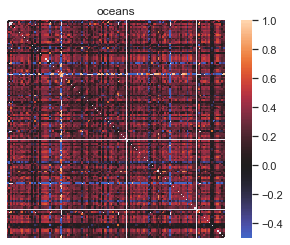

In [9]:
clip = "oceans"

fig, ax = plt.subplots()

sns.heatmap(isc_matrices[clip], center=0, ax=ax, square=True, vmin=-0.5, vmax=1, cbar=True)
ax.set_title(clip)

ax.set_xlabel('Subjects')
ax.set_ylabel('Subjects')

ax.xaxis.set_ticklabels('')
ax.yaxis.set_ticklabels('')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [10]:
isc_stats = pd.DataFrame(index=clip_list, columns=["mean", "median", "std"])

for clip in clip_list:
    iu1 = np.triu_indices_from(isc_matrices[clip])
    
    off_diag = isc_matrices[clip][iu1]
    
    isc_stats.loc[clip, "mean"] = np.nanmean(off_diag)
    isc_stats.loc[clip, "median"] = np.nanmedian(off_diag)
    isc_stats.loc[clip, "std"] = np.nanstd(off_diag)

isc_stats

,mean,median,std
twomen,0.255063,0.293759,0.206386
bridgeville,0.311436,0.390193,0.247228
pockets,0.334872,0.402499,0.242987
inception,0.258059,0.290485,0.191301
socialnet,0.343584,0.409566,0.270362
oceans,0.208504,0.25756,0.244717
flower,0.384627,0.426622,0.188564
hotel,0.417298,0.47385,0.199208
garden,0.274388,0.306662,0.156933
dreary,0.161006,0.172085,0.153248


In [11]:
cogn_median_vals = pd.read_csv("../data/cogn_median_val_trs-143.csv", squeeze=True).set_index("clip")
cogn_median_vals

,r_val
clip,
ocean's 11,0.342261
dreary,0.040545
garden,0.182495
hotel,0.141923
inception,0.222143
brokovich,0.187331
star wars,0.211377
two men,0.180369
pockets,0.216468


In [13]:
rename_dict = {
    "twomen": "two men",
    "oceans": "ocean's 11",
    "socialnet": "social net",
    "homealone": "home alone",
    "starwars": "star wars",
    "brokovich": "brockovich"

}

cogn_median_vals = cogn_median_vals.rename(index=rename_dict)
isc_stats = isc_stats.rename(index=rename_dict)

df 11
(0.05639109074188538, 0.8548154312856087)
SpearmanrResult(correlation=-0.06593406593406594, pvalue=0.8305423857560938)


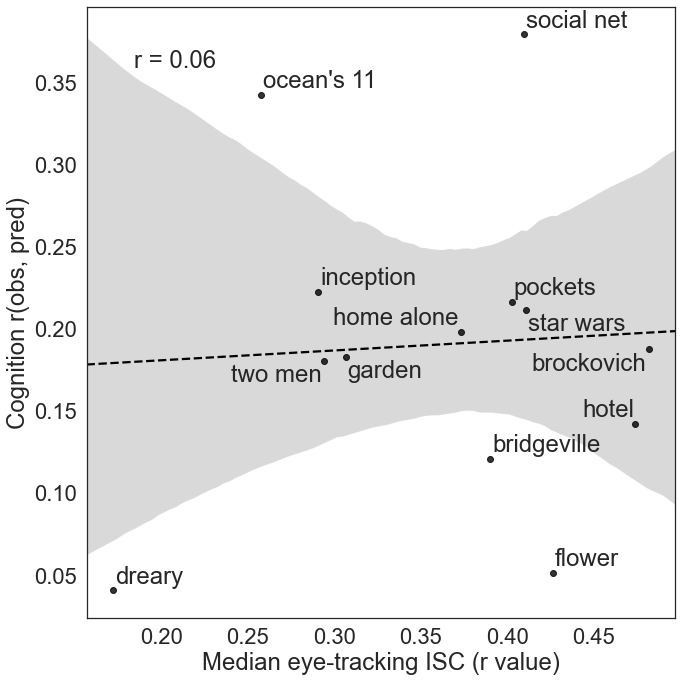

In [18]:
stat = "median"

x = isc_stats.loc[cogn_median_vals.index, stat]
y = cogn_median_vals.squeeze()

print("df {}".format(x.shape[0]-2))
print(sp.stats.pearsonr(x,y))
print(sp.stats.spearmanr(x,y))

r, p = sp.stats.pearsonr(x,y)

plt.rcParams.update({'font.size': 22})
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10,10),sharey=True)
sns.set(style="white", font_scale=2)

sns.regplot(x=x.values.astype(float), y=y.values.astype(float), color='black', truncate=False, line_kws={'linestyle': 'dashed'})
labels = [ax.annotate(txt, (x[i], y[i])) for i,txt in enumerate(x.index.values)]
adjust_text(labels)

ax.set_xlabel("Median eye-tracking ISC (r value)") # .format(stat))
ax.set_ylabel("Cognition r(obs, pred)")
ax.annotate(f"r = {r:.2f}", xy=(0.08, 0.9), xycoords='axes fraction')

fig.tight_layout()
# set_aspect_ratio(ax)

df 11
(0.6056110811793571, 0.028268279280212767)
SpearmanrResult(correlation=0.521978021978022, pvalue=0.06729171199351018)


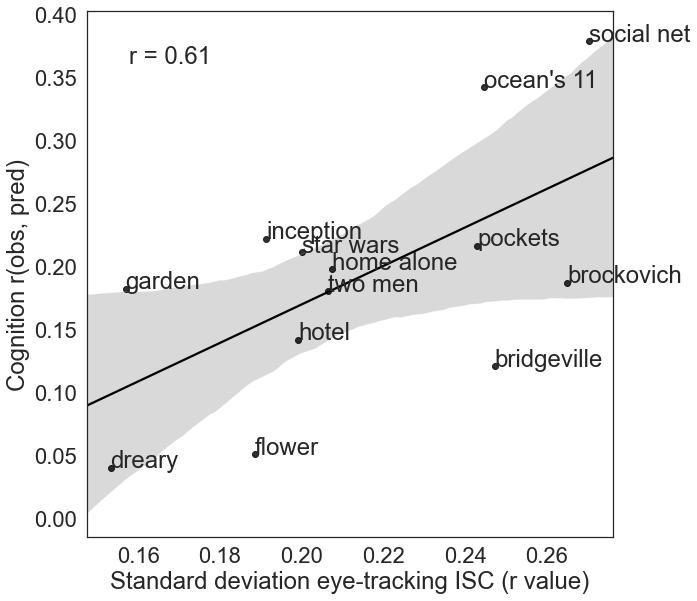

In [19]:
stat = "std"

x = isc_stats.loc[cogn_median_vals.index, stat]
y = cogn_median_vals.squeeze()

print("df {}".format(x.shape[0]-2))
print(sp.stats.pearsonr(x,y))
print(sp.stats.spearmanr(x,y))

r, p = sp.stats.pearsonr(x,y)

plt.rcParams.update({'font.size': 22})
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10,10))
sns.set(style="white", font_scale=2)

sns.regplot(x=x.values.astype(float), y=y.values.astype(float), color='black', truncate=False)
labels = [ax.annotate(txt, (x[i], y[i])) for i,txt in enumerate(x.index.values)]
# adjust_text(labels)

ax.set_xlabel("Standard deviation eye-tracking ISC (r value)") # .format(stat))
ax.set_ylabel("Cognition r(obs, pred)")
ax.annotate(f"r = {r:.2f}", xy=(0.08, 0.9), xycoords='axes fraction')

ax.set_aspect(1./ax.get_data_ratio())
fig.tight_layout()

## Compare blink-related measures across runs

In [19]:
blink_data_fname = '../data/blink_data_w_microsleeps.csv'
microsleep_length = 1000 # cutoff for microsleep (in ms)

if os.path.isfile(blink_data_fname):
    print("Loading blink data from preexisting file...")
    blink_data = pd.read_csv(blink_data_fname, dtype={'subject': 'str'})
    print("...done!")
    
else:
    print("Creating blink data from individual subject logs...")
    
    blink_data = pd.DataFrame(columns=["subject", "scan", "n_blinks", "mean_blink_dur", "median_blink_dur", "n_microsleeps"])

    for s,subj in enumerate(eye_data.subject.unique()):
        print("Doing subject {} of {}".format(s+1, len(eye_data.subject.unique())))
        for scan in ["REST1", "REST4", "MOV1", "MOV2", "MOV3", "MOV4"]:

            tmp = {}
            tmp["subject"] = subj
            tmp["scan"] = scan

            file = str(subj) + '_7T_' + scan + '_eyetrack.asc'

            with open(data_dir+file, 'r') as f:
                line_no=0
                n_blink_starts=0
                n_blink_ends=0
                blink_dur=[]
                for line in f:
                    line_no +=1
                    if 'SBLINK' in line:
                        n_blink_starts+=1
                    if 'EBLINK' in line:
                        n_blink_ends+=1
                        blink_dur.append(int(line.split()[-1]))

            tmp["n_blinks"] = n_blink_ends
            tmp["mean_blink_dur"] = np.mean(blink_dur)
            tmp["median_blink_dur"] = np.median(blink_dur)
            tmp["n_microsleeps"] = (np.array(blink_dur) > microsleep_length).sum()

            blink_data = blink_data.append(tmp, ignore_index=True)

    blink_data.head()
    blink_data.to_csv(blink_data_fname, index=False)

Creating blink data from individual subject logs...
Doing subject 1 of 166
Doing subject 2 of 166
Doing subject 3 of 166
Doing subject 4 of 166
Doing subject 5 of 166
Doing subject 6 of 166
Doing subject 7 of 166
Doing subject 8 of 166
Doing subject 9 of 166
Doing subject 10 of 166
Doing subject 11 of 166
Doing subject 12 of 166
Doing subject 13 of 166
Doing subject 14 of 166
Doing subject 15 of 166
Doing subject 16 of 166
Doing subject 17 of 166
Doing subject 18 of 166
Doing subject 19 of 166
Doing subject 20 of 166
Doing subject 21 of 166
Doing subject 22 of 166
Doing subject 23 of 166
Doing subject 24 of 166


/data/finnes/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/finnes/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Doing subject 25 of 166
Doing subject 26 of 166
Doing subject 27 of 166
Doing subject 28 of 166
Doing subject 29 of 166
Doing subject 30 of 166
Doing subject 31 of 166
Doing subject 32 of 166
Doing subject 33 of 166
Doing subject 34 of 166
Doing subject 35 of 166
Doing subject 36 of 166
Doing subject 37 of 166
Doing subject 38 of 166
Doing subject 39 of 166
Doing subject 40 of 166
Doing subject 41 of 166
Doing subject 42 of 166
Doing subject 43 of 166
Doing subject 44 of 166
Doing subject 45 of 166
Doing subject 46 of 166
Doing subject 47 of 166
Doing subject 48 of 166
Doing subject 49 of 166
Doing subject 50 of 166
Doing subject 51 of 166
Doing subject 52 of 166
Doing subject 53 of 166
Doing subject 54 of 166
Doing subject 55 of 166
Doing subject 56 of 166
Doing subject 57 of 166
Doing subject 58 of 166
Doing subject 59 of 166
Doing subject 60 of 166
Doing subject 61 of 166
Doing subject 62 of 166
Doing subject 63 of 166
Doing subject 64 of 166
Doing subject 65 of 166
Doing subject 66

In [20]:
blink_data = blink_data.replace(short_to_long)

In [21]:
blink_data.head()

,subject,scan,n_blinks,mean_blink_dur,median_blink_dur,n_microsleeps
0,134627,REST1,222,2309.797297,402.0,67
1,134627,REST4,557,417.247756,170.0,30
2,134627,MOVIE1,320,1320.221875,172.5,44
3,134627,MOVIE2,398,497.522613,123.0,22
4,134627,MOVIE3,491,278.892057,145.0,12


In [22]:
print("Found blink data for {} subjects and {} scans".format(len(blink_data.subject.unique()), blink_data.shape[0]))

# Remove rows with NaNs
blink_data = blink_data[~blink_data.isnull().any(axis=1)]
print("After removing scans with no blink data, {} subjects and {} scans remain".format(len(blink_data.subject.unique()), blink_data.shape[0]))

Found blink data for 166 subjects and 996 scans
After removing scans with no blink data, 164 subjects and 931 scans remain


It looks like for some files, there was one blink recorded for basically the whole duration of the scan, which is really throwing off the numbers. Let's try liming this to scans where morethan 1 blink was detected

In [23]:
blink_data = blink_data[(blink_data["n_blinks"]>10) & (blink_data["n_blinks"]<3000)]
print("After removing scans with way too few or way too many blinks, {} subjects and {} scans remain".format(len(blink_data.subject.unique()), blink_data.shape[0]))

blink_data = blink_data[(blink_data["median_blink_dur"] < 10000)]
print("After removing scans with an unreasonable value for median_blink_dur, {} subjects and {} scans remain".format(len(blink_data.subject.unique()), blink_data.shape[0]))

After removing scans with way too few or way too many blinks, 163 subjects and 897 scans remain
After removing scans with an unreasonable value for median_blink_dur, 163 subjects and 897 scans remain


Convert raw number of blinks to blink rate:

In [24]:
run_length_lookup = {
        "MOVIE1": 921,
        "MOVIE2": 918,
        "MOVIE3": 915,
        "MOVIE4": 901,
        "REST1": 900,
        "REST4": 900,
    }

blink_rate = []

for index, row in blink_data.iterrows():
    scan = row["scan"]
    blink_rate.append(row["n_blinks"]/(run_length_lookup[scan]/60))

    
blink_data["blink_rate"]= blink_rate

In [25]:
blink_data.head()

,subject,scan,n_blinks,mean_blink_dur,median_blink_dur,n_microsleeps,blink_rate
0,134627,REST1,222,2309.797297,402.0,67,14.800000
1,134627,REST4,557,417.247756,170.0,30,37.133333
2,134627,MOVIE1,320,1320.221875,172.5,44,20.846906
3,134627,MOVIE2,398,497.522613,123.0,22,26.013072
4,134627,MOVIE3,491,278.892057,145.0,12,32.196721


In [26]:
blink_data_wide = blink_data.pivot(index="subject", columns="scan")
blink_data_wide.index = blink_data_wide.index.map(str)
print(blink_data_wide.shape)
blink_data_wide.head()

(163, 30)


n_blinks                                    mean_blink_dur  \
scan      MOVIE1 MOVIE2 MOVIE3 MOVIE4  REST1  REST4         MOVIE1   
subject                                                              
100610     311.0  154.0  190.0  250.0  307.0  209.0     179.327974   
102311     255.0   36.0  573.0  416.0    NaN  557.0    3907.498039   
102816     193.0  293.0  405.0  339.0  354.0  107.0    4780.756477   
104416     951.0  894.0  684.0  727.0    NaN  670.0     893.257624   
105923     198.0  153.0  103.0   96.0  210.0  160.0     200.676768   

                                                 ... n_microsleeps         \
scan           MOVIE2       MOVIE3       MOVIE4  ...        MOVIE3 MOVIE4   
subject                                          ...                        
100610     152.740260   173.284211   209.924000  ...           0.0    1.0   
102311   27848.527778   415.073298   868.514423  ...          24.0   47.0   
102816    2860.576792  2052.049383  2648.017699  ...          96.0   76.0   
104416     631.128635   499.115497   312.246217  ...          49.0   23.0   
105923     242.705882   336.708738   339.979167  ...           6.0    5.0   

                    blink_rate                                              \
scan    REST1 REST4     MOVIE1     MOVIE2     MOVIE3     MOVIE4      REST1   
subject                                                                      
100610    6.0   0.0  20.260586  10.065359  12.459016  16.648169  20.466667   
102311    NaN  58.0  16.612378   2.352941  37.573770  27.702553        NaN   
102816   97.0  42.0  12.573290  19.150327  26.557377  22.574917  23.600000   
104416    NaN  65.0  61.954397  58.431373  44.852459  48.412875        NaN   
105923   57.0   8.0  12.899023  10.000000   6.754098   6.392897  14.000000   

                    
scan         REST4  
subject             
100610   13.933333  
102311   37.133333  
102816    7.133333  
104416   44.666667  
105923   10.666667  

[5 rows x 30 columns]

Performing paired t-test on pair: ('REST1', 'MOVIE1') stat=-5.68e+00 p-value=7.93e-08 df=133
Performing paired t-test on pair: ('REST1', 'MOVIE2') stat=-3.14e+00 p-value=2.06e-03 df=132
pvalues: [7.92788615956908e-08, 0.0020649326380924008]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST1 v.s. MOVIE1: Custom statistical test, P_val:7.928e-08
REST1 v.s. MOVIE2: Custom statistical test, P_val:2.065e-03
Performing paired t-test on pair: ('REST4', 'MOVIE3') stat=-1.95e+00 p-value=5.30e-02 df=136
Performing paired t-test on pair: ('REST4', 'MOVIE4') stat=-1.76e+00 p-value=8.06e-02 df=136
pvalues: [0.05297039786330051, 0.08061574283917801]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST4 v.s. MOVIE3: Custom statistical test, P_val:5.297e-02
REST4 v.s. MO

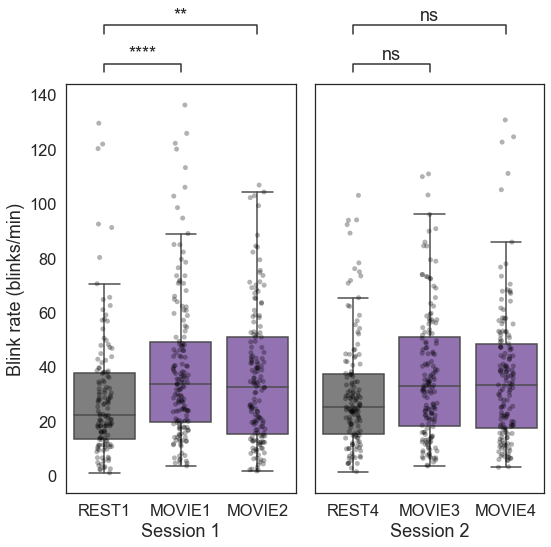

In [28]:
# Plot distributions
save_fig = False

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8), sharey=True)

data = blink_data
x = 'scan'
y = 'blink_rate' # median_blink_dur, blink_rate, n_microsleeps
ylabel = "Blink rate (blinks/min)"
outlier_cutoff = 150 # for median_blink_dir, 500 is a good one; for n_blinks, 1600 is a good one; for blink_rate, 150 is a good one
palette = my_palette


# -------------------------------------------------------------------------------------
# Do session 1
ax = ax1
order1 = ["REST1", "MOVIE1", "MOVIE2"]
sns.boxplot(data=data, x=x, y=y,
              order=order1,
              palette = palette,
              ax=ax,
              showfliers=False # hide outliers
             )
sns.stripplot(data=data[data[y] < outlier_cutoff], x=x, y=y,
              order=order1,
              color='black', alpha=0.3,
              ax=ax
             )

box_pairs=[("REST1", "MOVIE1"), ("REST1", "MOVIE2")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = blink_data_wide.loc[:,y][pair[0]]
    data2 = blink_data_wide.loc[:,y][pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df={}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)

test_results = add_stat_annotation(ax, data=data, x=x, y=y, order=order1,
                                  box_pairs=box_pairs,
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  # line_offset_to_box=-0.5
                                  )

# Do session 2
ax = ax2
order2 = ["REST4", "MOVIE3", "MOVIE4"]

sns.boxplot(data=data, x=x, y=y,
              order=order2,
              palette = palette,
              ax=ax,
              showfliers=False # hide outliers
             )
sns.stripplot(data=data[data[y] < outlier_cutoff], x=x, y=y,
              order=order2,
              color='black', alpha=0.3,
              ax=ax
             )

box_pairs=[("REST4", "MOVIE3"), ("REST4", "MOVIE4")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = blink_data_wide.loc[:,y][pair[0]]
    data2 = blink_data_wide.loc[:,y][pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df={}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)
test_results = add_stat_annotation(ax, data=data, x=x, y=y,order=order2,
                                  box_pairs=box_pairs,
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  )

sns.set(font_scale=1.5, style="white")

ax1.set_xlabel("Session 1")
ax2.set_xlabel("Session 2")

ax1.set_ylabel(ylabel)
ax2.yaxis.label.set_visible(False)

fig.tight_layout()

if save_fig == True:
    plt.savefig(''.join(['figures/', y, '.jpg']), dpi=300)

### Look at correlations among blink-related measures

In [29]:
corr_table = blink_data.groupby("scan")["blink_rate", "median_blink_dur", "n_microsleeps"].corr()
corr_table = corr_table.loc[runs_of_interest]
corr_table

/data/finnes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


blink_rate  median_blink_dur  n_microsleeps
scan                                                                
MOVIE1 blink_rate          1.000000         -0.312291       0.435590
       median_blink_dur   -0.312291          1.000000      -0.046815
       n_microsleeps       0.435590         -0.046815       1.000000
MOVIE2 blink_rate          1.000000         -0.243762       0.464520
       median_blink_dur   -0.243762          1.000000       0.048765
       n_microsleeps       0.464520          0.048765       1.000000
MOVIE3 blink_rate          1.000000         -0.297931       0.407524
       median_blink_dur   -0.297931          1.000000       0.142203
       n_microsleeps       0.407524          0.142203       1.000000
MOVIE4 blink_rate          1.000000         -0.320148       0.329554
       median_blink_dur   -0.320148          1.000000       0.061246
       n_microsleeps       0.329554          0.061246       1.000000
REST1  blink_rate          1.000000         -0.220858       0.331868
       median_blink_dur   -0.220858          1.000000       0.227748
       n_microsleeps       0.331868          0.227748       1.000000
REST4  blink_rate          1.000000         -0.140847       0.506924
       median_blink_dur   -0.140847          1.000000       0.098291
       n_microsleeps       0.506924          0.098291       1.000000

In [30]:
corr_table.mean(level=1)

,blink_rate,median_blink_dur,n_microsleeps
blink_rate,1.000000,-0.255973,0.412663
median_blink_dur,-0.255973,1.000000,0.088573
n_microsleeps,0.412663,0.088573,1.000000


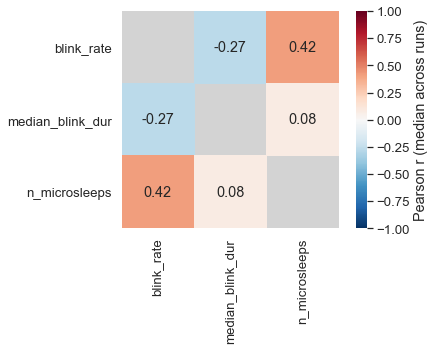

In [31]:
corr_table_median = corr_table.median(level=1)
np.fill_diagonal(corr_table_median.values, np.nan)

sns.set(font_scale=1.2)
g = sns.heatmap(corr_table_median, center=0, vmin=-1, vmax=1, 
                cmap='RdBu_r', cbar_kws={'label': 'Pearson r (median across runs)'},
                square=True, annot=True)
g.set_facecolor("lightgray")